# Routing through a sequence

This demo uses the basal ganglia model to cycle through a sequence of five representations. The model incorporates a memory, which allows the basal ganglia to update that memory based on a set of condition/action mappings. The mappings are defined in the code such that A$\rightarrow$B, B$\rightarrow$C, etc. until E$\rightarrow$A completing a loop. 

When you run this demo, the sequence will be repeated indefinitely. It is interesting to note the time between the ‘peaks’ of the selected items. It's about 40ms for this simple action.

In [1]:
# Setup for the notebook
%matplotlib inline

import nengo
import matplotlib.pyplot as plt

import nengo_spa as spa

seed = 0

## Step 1: Create the model

Notice that when you specify actions, you're determining which modules are connected to which.  For example, by having a mapping that depends on the state of cortex, you are determining that the cortex and basal ganglia must be connected.  As well, when you specify that the result of the action changes the state of cortex, then you are determining that thalamus must be connected to cortex.

In [2]:
def start(t):
    """Set initial state for model"""
    if t < 0.05:
        return 'A'
    else:
        return '0'


# Number of dimensions for the Semantic Pointers
dimensions = 16

# Make a model object with the SPA network
model = spa.Network(label='Sequence_Network', seed=seed)

with model:
    # Specify the modules to be used
    stimulus = spa.Transcode(start, output_vocab=dimensions)
    cortex = spa.State(dimensions)
    stimulus >> cortex  # sets initial state for model

    # Specify the action mapping
    with spa.ActionSelection() as action_sel:
        spa.ifmax("A to B",
                  spa.dot(cortex, spa.sym.A),
                  spa.sym.B >> cortex)
        spa.ifmax("B to C",
                  spa.dot(cortex, spa.sym.B),
                  spa.sym.C >> cortex)
        spa.ifmax("C to D",
                  spa.dot(cortex, spa.sym.C),
                  spa.sym.D >> cortex)
        spa.ifmax("D to E",
                  spa.dot(cortex, spa.sym.D),
                  spa.sym.E >> cortex)
        spa.ifmax("E to A",
                  spa.dot(cortex, spa.sym.E),
                  spa.sym.A >> cortex)

## Step 3: Probe the output

In [3]:
with model:
    p_cortex = nengo.Probe(cortex.output, synapse=0.01)
    p_selected_actions = nengo.Probe(action_sel.thalamus.output, synapse=0.01)
    p_utility = nengo.Probe(action_sel.bg.input, synapse=0.01)

## Step 4: Run the model

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

## Step 5: Plot the results

Plot the results of the simulation. The first figure shows the semantic pointer representation of the values stored in the "cortex" module. The second figure shows the actions being executed, and the third figure shows the utility (similarity) of the cortex representation to the conditions of each action.

Text(0, 0.5, 'Utility')

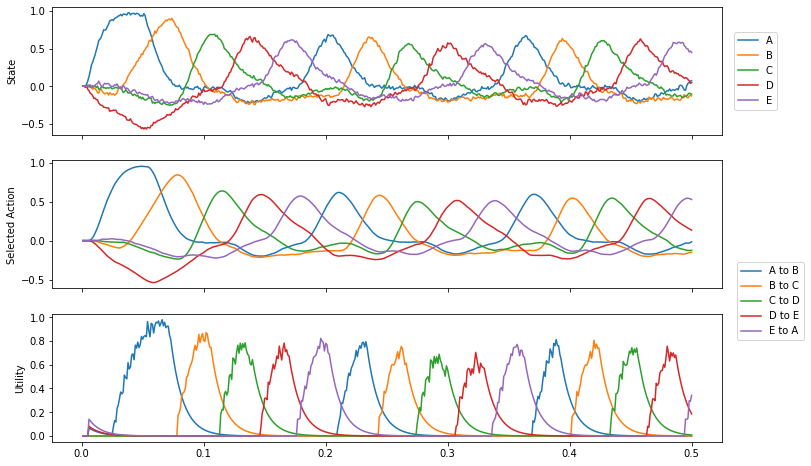

In [5]:
vocab = model.vocabs[dimensions]

fig, (p1, p2, p3) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))

p1.plot(sim.trange(), spa.similarity(sim.data[p_cortex], vocab))
p1.legend(vocab.keys(), loc='right', bbox_to_anchor=(1.09, 0.5))
p1.set_ylabel('State')

p2.plot(sim.trange(), sim.data[p_utility])
p2.legend(tuple(action_sel.keys()), loc='right', bbox_to_anchor=(1.13, -0.1))
p2.set_ylabel('Selected Action')

p3.plot(sim.trange(), sim.data[p_selected_actions])
p3.set_ylabel('Utility')